In [ ]:
#容量を増やす処理
import cupy as cp
pool = cp.cuda.MemoryPool(cp.cuda.malloc_managed)
cp.cuda.set_allocator(pool.malloc)

In [ ]:
#バージョン指定のインストール
!pip install chainer==6.5.0 --no-cache-dir
!pip install chainercv # ChainerCVのインストール

import chainer

chainer.print_runtime_info()

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for chainercv: filename=chainercv-0.13.1-cp36-cp36m-linux_x86_64.whl size=537359 sha256=dae1ceeb1bcb4537a50a8aae09bbe7e7301a76a4d713e25656373d5543ca3028
  Stored in directory: /root/.cache/pip/wheels/ea/10/01/e221beaa4b3d8341aa819a39ab8d4677457c79c81f521f3a94
Successfully built chainercv
Platform: Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.5.0
ChainerX: Not Available
NumPy: 1.17.4
CuPy:
  CuPy Version          : 6.5.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuDNN Build Version   : 7603
  cuDNN Version         : 7603
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


In [ ]:
#googledriveをマウント(googledriveのフォルダなどを使用可能にすること)
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#画像処理ライブラリ
#opencvよりコードがシンプル
#高度な画像処理は不可能
import PIL

In [ ]:
%cd drive
%cd My Drive

/content/drive
/content/drive/My Drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
#pathの処理
p = Path('.')
raw_dir = p / 'BCCD_test' / 'JPEGImages'

In [ ]:
#条件を満たすパスの文字列を要素とするリストをpathsに格納
paths = list(raw_dir.glob('*.jpg'))

In [ ]:
#pictureの数
len(paths)

2348

In [ ]:
#ランダムに画像データを8:2に分割
train_paths, val_paths = train_test_split(paths, test_size=0.2, shuffle=True)

In [ ]:
#stem=拡張子なしのファイル名の文字列を取得
train_paths = [path.stem for path in train_paths]
val_paths = [path.stem for path in val_paths]

In [ ]:
path_t = p  / 'BCCD_test' / 'ImageSets' / 'Main' / 'train.txt'
path_v = p  / 'BCCD_test' / 'ImageSets' / 'Main' / 'val.txt'

In [ ]:
#train_pathに入っているtrainデータをtrain.txtに書き込む処理
with open(path_t, mode='w') as f:
    f.write("\n".join(train_paths))
#val_pathに入っているvalデータをval.txtに書き込む処理
with open(path_v, mode='w') as f:
    f.write("\n".join(val_paths))

In [ ]:
import os
#xml.etree.ElementTree=XMLを取得して読み取るモジュール
import xml.etree.ElementTree as ET

import numpy as np

from chainercv.datasets import VOCBboxDataset


labels = ('bat', 'human')


class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]

        # Pascal VOC形式のアノテーションデータは，XML形式で配布されています
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))

        # XMLを読み込んで，bboxの座標・大きさ，bboxごとのクラスラベルなどの
        # 情報を取り出し，リストに追加していきます
        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')

            # bboxの座標値が0-originになるように1を引いています
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)

        # オリジナルのPascal VOCには，difficultという
        # 属性が画像ごとに真偽値で与えられていますが，今回は用いません
        # （今回のデータセットでは全画像がdifficult = 0に設定されているため）
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

In [ ]:
train_dataset = BCCDDataset('BCCD_test', 'train')
valid_dataset = BCCDDataset('BCCD_test', 'val')

In [ ]:
print('Number of images in "train" dataset:', len(train_dataset))
print('Number of images in "valid" dataset:', len(valid_dataset))

Number of images in "train" dataset: 1878
Number of images in "valid" dataset: 470


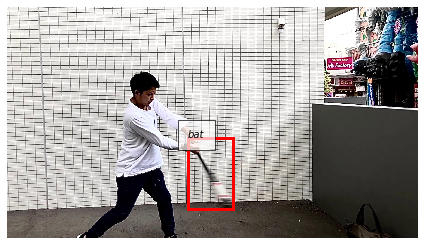

In [ ]:
%matplotlib inline
from chainercv.visualizations import vis_bbox

img, bbox, label = train_dataset[1]
ax = vis_bbox(img, bbox, label, label_names=labels)
ax.set_axis_off()
ax.figure.tight_layout()

In [ ]:
import chainer
from chainercv.links import SSD300
from chainercv.links.model.ssd import multibox_loss

class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        
        with self.init_scope():
            self.model = model
        #alpha=位置の予測に対する誤差と
        #クラスの予測に対する誤差それぞれの間の重み付けを行う係数
        self.alpha = alpha
        #hard negative mining のためのパラメータ
        self.k = k
    #入力画像と正解の位置・ラベルのリストを受け取って，実際にロスの計算を行う関数
    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss
#SSD300=入力サイズが縦横300ピクセルのネットワーク構造のこと
model = SSD300(n_fg_class=len(labels), pretrained_model='imagenet')
train_chain = MultiboxTrainChain(model)

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /root/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   5217KiB/s    0:00:00

/usr/local/lib/python3.6/dist-packages/chainercv/utils/link.py:72: RuntimeWarning: Although the pretrained model is trained using cv2 as the backend of resize function, the current setting does not use cv2 as the backend of resize function. The performance may change due to using different backends. To suppress this warning, set `chainer.config.cv_resize_backend = "cv2".
  RuntimeWarning)


## Data Augumentaionの実装
データを擬似的に増やすようにデータの意味を変えずに様々な変換を画像とそれに付随するラベルに適用するテクニック 

In [ ]:
import copy
from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [ ]:
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling

chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.config.autotune = True

In [ ]:
#バッチサイズ
batchsize = 64
#使用するGPUのID
gpu_id = 0
#結果の出力ディレクトリ名
out = 'results'
#学習率初期値
initial_lr = 0.001
#学習を行うエポック数
training_epoch = 300
#10エポックごと
log_interval = 10, 'epoch'
lr_decay_rate = 0.1
lr_decay_timing = [200, 250]

In [ ]:
transformed_train_dataset = TransformDataset(train_dataset, Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, repeat=False, shuffle=False)

In [ ]:
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

In [ ]:

updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(
    updater,
    (training_epoch, 'epoch'), out)

In [ ]:
trainer.extend(
    extensions.ExponentialShift('lr', lr_decay_rate, init=initial_lr),
    trigger=triggers.ManualScheduleTrigger(lr_decay_timing, 'epoch'))

In [ ]:
trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=labels),
    trigger=(1, 'epoch'))

trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map', 'elapsed_time']),
    trigger=log_interval)
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss', 'main/loss/loc', 'main/loss/conf'],
            'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['validation/main/map'],
            'epoch', file_name='accuracy.png'))
trainer.extend(extensions.snapshot(
    filename='20191203_epoch_{.updater.epoch}.npz'), trigger=(10, 'epoch'))

In [ ]:
chainer.serializers.load_npz('./results/20191203_epoch_140.npz', trainer)

In [ ]:
trainer.run()

/usr/local/lib/python3.6/dist-packages/chainer/iterators/multiprocess_iterator.py:27: TimeoutWarning: Stalled dataset is detected. See the documentation of MultiprocessIterator for common causes and workarounds:
https://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html
  MultiprocessIterator.TimeoutWarning)
Exception in main training loop: out of memory to allocate 1073741824 bytes (total 12212723712 bytes)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/trainer.py", line 316, in run
    update()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 175, in update
    self.update_core()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 187, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python3.6/dist-packages/chainer/optimizer.py", line 869, in update
    loss.backw

OutOfMemoryError: ignored

/usr/local/lib/python3.6/dist-packages/chainercv/utils/link.py:72: RuntimeWarning: Although the pretrained model is trained using cv2 as the backend of resize function, the current setting does not use cv2 as the backend of resize function. The performance may change due to using different backends. To suppress this warning, set `chainer.config.cv_resize_backend = "cv2".
  RuntimeWarning)


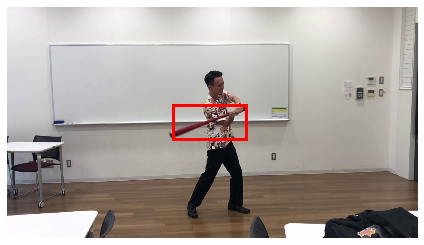

In [ ]:
model = SSD300(n_fg_class=len(labels), pretrained_model='imagenet')

# Load parameters to the model
chainer.serializers.load_npz(
    'results/20191203_epoch_140.npz', model, path='updater/model:main/model/')

from chainercv import utils

def inference(image_filename):
    # Load a test image
    img = utils.read_image(image_filename, color=True)

    # Perform inference
    bboxes, labels, scores = model.predict([img])

    # Extract the results
    bbox, label, score = bboxes[0], labels[0], scores[0]

    # Visualize the detection results
    ax = vis_bbox(img, bbox,label_names=labels)
    ax.set_axis_off()
    ax.figure.tight_layout()

inference('BCCD_test/JPEGImages/picture036.jpg')

### 予測

In [ ]:
model = SSD300(n_fg_class=len(labels), pretrained_model='imagenet')

# Load parameters to the model
chainer.serializers.load_npz(
    'results/20191203_epoch_140.npz', model, path='updater/model:main/model/')

from chainercv import utils

import os
import shutil
import cv2
import matplotlib.pyplot as plt


#元の動画の情報を見て、1920 ×　1080　のようにサイズを合わせる
w = 1920
h = 1080

#動画の半分のスピードになります。　　３０にすれば1倍の速さ。　ex. 10 =  3分の１の速さ
speed = 30

#movie_nameにGoogle Driveの動画名を入れる
movie_name = './大学/動画/takamatsu.mov'

import cv2

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video  = cv2.VideoWriter('./大学/動画/takamatsu.mp4', fourcc, speed, (w, h))
print('---')
if __name__ == '__main__':

    length_list = []
    center_list =[]
    count = 0
    cap = cv2.VideoCapture(movie_name)

    image_dir='./大学/動画/a/'
    image_file='img_%s.png'
    file_name = image_dir+image_file % str(count).zfill(6)
    values = []
    keys = []

    if os.path.exists(image_dir):
        shutil.rmtree(image_dir)  

    # Make the directory if it doesn't exist.
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    while True:
        ret, frame = cap.read()

        if ret == True:
            count += 1
            
            img = cv2.imwrite(file_name, frame)
            img = utils.read_image(file_name, color=True)
            bboxes, labels, scores = model.predict([img])
            bbox, label, score = bboxes[0], labels[0], scores[0]
            if bbox.any():
              upper_left = np.array([bbox[0][1], bbox[0][0]])
              bottom_right = np.array([bbox[0][3], bbox[0][2]])
              length = bottom_right - upper_left
              center = (upper_left + bottom_right) / 2
              keys.append(count)
              values.append(center)

              #center_list.update(zip(keys, values))
              #center_list.extend(keys)
              #center_list.extend(values)
              length_list.append(np.linalg.norm(length))
              #print(center_list)

              
        else:
            break
    video.release()

k=[]
#index=keysのインデックス番号の範囲
index=range(len(keys))
for i in index:

  #index値が最大でない時
  if not i==max(index):
    #sa_dist=i+1番目とi番目のバット中心の差の距離
    sa_dist=np.linalg.norm(values[i+1]-values[i])

    #one_sa_dist=一枚当たりのバット中心の差の距離
    #kに一枚当たりのバットの移動距離の差を格納
    one_sa_dist=sa_dist/(keys[i+1]-keys[i])
    k.append(one_sa_dist)
    #index値が最後の時
  else:
    k.append(0)

#k_max=kの最大値
k_max=max(k)
#
bat_dist=1/max(length_list)
bat_sp=k_max*bat_dist*1.06*240*3600/1000

print('スイングスピード;',round(bat_sp,0),'km/h')

    # np.max(out[0])

/usr/local/lib/python3.6/dist-packages/chainercv/utils/link.py:72: RuntimeWarning: Although the pretrained model is trained using cv2 as the backend of resize function, the current setting does not use cv2 as the backend of resize function. The performance may change due to using different backends. To suppress this warning, set `chainer.config.cv_resize_backend = "cv2".
  RuntimeWarning)


---
スイングスピード; 46.0 km/h
